In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
from sklearn import linear_model
import scipy
import tensorflow as tf
import pandas as pd 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def BER(predictions, y):
    TP = sum([(p and l) for (p,l) in zip(predictions, y)])
    FP = sum([(p and not l) for (p,l) in zip(predictions, y)])
    TN = sum([(not p and not l) for (p,l) in zip(predictions, y)])
    FN = sum([(not p and l) for (p,l) in zip(predictions, y)])
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    BER = 1 - 1/2 * (TPR + TNR)
    return BER

In [4]:
data = pd.read_pickle("..\\data\\renttherunway_data_processed.pkl")
#data = pd.DataFrame(processed_data).to_dict('record')
data.dtypes

fit                       object
user_id                    int64
bust size                 object
item_id                    int64
weight                   float64
rating                   float64
rented for                object
review_text               object
body type                 object
review_summary            object
category                  object
height                   float64
size                       int64
age                      float64
review_date       datetime64[ns]
review_year                int64
review_month               int64
adjectives                 int64
review_length              int64
review_words               int64
review_ex                  int64
dtype: object

In [5]:
bustsize = lambda x: x[2:]
data["cup size"] = data["bust size"].apply(bustsize)


In [6]:
bustsize = lambda x: x[2:]
data["strap size"] = data["bust size"].apply(bustsize)


In [7]:
data["strap size"]

0          d
1          b
3          c
4          b
5          b
          ..
192539    dd
192540     c
192541     a
192542     c
192543     b
Name: strap size, Length: 165128, dtype: object

In [8]:
feature_list = []

In [9]:
#features to consider for the model 
bustsize = lambda x: int(x[0:2])
data["bust size"] = data["bust size"].apply(bustsize)

In [10]:
btype_data = data["body type"].value_counts()
btypes = list(btype_data.keys())
feature_list += (btypes)
for btype in btypes:
    bfun = lambda x: 1 if (x==btype) else 0
    data[btype] = data["body type"].apply(bfun)

In [11]:
rtype_data = data["rented for"].value_counts()
rtypes = list(rtype_data.keys())
feature_list += rtypes
for rtype in rtypes:
    rfun = lambda x: 1 if (x==rtype) else 0
    data[rtype] = data["body type"].apply(rfun)

In [12]:
feature_list.remove('party: cocktail')

In [13]:
data.dtypes

fit                          object
user_id                       int64
bust size                     int64
item_id                       int64
weight                      float64
rating                      float64
rented for                   object
review_text                  object
body type                    object
review_summary               object
category                     object
height                      float64
size                          int64
age                         float64
review_date          datetime64[ns]
review_year                   int64
review_month                  int64
adjectives                    int64
review_length                 int64
review_words                  int64
review_ex                     int64
cup size                     object
strap size                   object
hourglass                     int64
athletic                      int64
pear                          int64
petite                        int64
straight & narrow           

In [14]:
def feature(d):
    f = [1,
         d['rating'],
         d['review_length'],
         len(d['review_summary']),
         d['weight'],
         d['age'],
         d['height'],
         d['bust size']]
    for e in feature_list:
        f.append(d[e])
    return f

In [35]:
inputdata = pd.DataFrame(data).to_dict('record')
X = [feature(d) for d in inputdata]
y = [d['fit'] for d in inputdata]


In [36]:
import numpy as np

In [37]:
categories, y_categorical = np.unique(y, return_inverse=True)

In [38]:
categories, y_categorical

(array(['fit', 'large', 'small'], dtype='<U5'),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [39]:
def one_hot_encoding(y_categorical):
    n = y_categorical.shape[0]
    m = np.max(y_categorical) + 1
    y_one_hot = np.zeros([n, m])
    for i in range(n):
        if y_categorical[i] == 0:
            y_one_hot[i, 0] = 1
        elif y_categorical[i] == 1:
            y_one_hot[i, 1] = 1
        elif y_categorical[i] == 2:
            y_one_hot[i, 2] = 1
    return y_one_hot

In [40]:
y_one_hot = one_hot_encoding(y_categorical)

In [41]:
y_one_hot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [42]:
## CATEGORIES ##
## FIT: 0     ##
## LARGE: 1   ##
## SMALL: 2   ##

In [43]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)


In [44]:
X_train = X[0:int(0.8*len(data))]
X_test = X[int(0.8*len(data)):]

y_train = y_one_hot[0:int(0.8*len(data))]
y_test = y_one_hot[int(0.8*len(data)):]

In [46]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

## Deep Learning Model

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

In [48]:
model = Sequential()
model.add(Dense(60, input_shape = (len(X_train[0]), ), activation = "relu"))
model.add(Dense(40, activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(3, activation = "softmax"))
model.compile(Adam(lr = 0.001), "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1440      
                                                                 
 dense_1 (Dense)             (None, 40)                2440      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 123       
                                                                 
Total params: 4,003
Trainable params: 4,003
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(X_train, y_train, verbose=1, epochs=10)


Epoch 1/10
4129/4129 [==============================] - 3s 676us/step - loss: 0.8867 - accuracy: 0.7287
Epoch 2/10
4129/4129 [==============================] - 3s 655us/step - loss: 0.7533 - accuracy: 0.7366
Epoch 3/10
4129/4129 [==============================] - 3s 674us/step - loss: 0.7490 - accuracy: 0.7366
Epoch 4/10
4129/4129 [==============================] - 3s 726us/step - loss: 0.7432 - accuracy: 0.7366
Epoch 5/10
4129/4129 [==============================] - 3s 706us/step - loss: 0.7391 - accuracy: 0.7368
Epoch 6/10
4129/4129 [==============================] - 3s 707us/step - loss: 0.7354 - accuracy: 0.7372
Epoch 7/10
4129/4129 [==============================] - 3s 694us/step - loss: 0.7341 - accuracy: 0.7372
Epoch 8/10
4129/4129 [==============================] - 3s 704us/step - loss: 0.7337 - accuracy: 0.7369
Epoch 9/10
4129/4129 [==============================] - 3s 721us/step - loss: 0.7335 - accuracy: 0.7370
Epoch 10/10
4129/4129 [==============================] - 3s 718u

## Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix

y_test_class = np.argmax(y_test, axis=1)


y_test_pred = model.predict(X_test)
y_test_class_pred = np.argmax(y_test_pred, axis=1)
confusion_matrix(y_test_class, y_test_class_pred)

array([[24201,    25,   120],
       [ 4145,    42,    73],
       [ 4266,    16,   138]], dtype=int64)

## Classification report

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_test_class_pred), digits=4)

              precision    recall  f1-score   support

           0       0.74      0.99      0.85     24346
           1       0.51      0.01      0.02      4260
           2       0.42      0.03      0.06      4420

    accuracy                           0.74     33026
   macro avg       0.56      0.35      0.31     33026
weighted avg       0.67      0.74      0.64     33026



In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_test_class_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7413    0.9946    0.8495     24346
           1     0.0000    0.0000    0.0000      4260
           2     0.3934    0.0321    0.0594      4420

    accuracy                         0.7375     33026
   macro avg     0.3782    0.3422    0.3030     33026
weighted avg     0.5991    0.7375    0.6341     33026



In [30]:
y_test_class

array([0, 2, 0, ..., 0, 0, 0], dtype=int64)

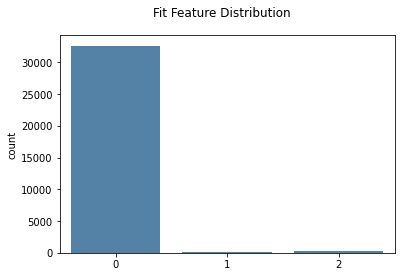

In [31]:
fig = sns.countplot(y_test_class_pred, color='steelblue').get_figure()
fig.suptitle("Fit Feature Distribution")
fig.savefig("fit_statistics.png")

In [56]:
model2 = Sequential()
model2.add(Dense(80, input_shape = (len(X_train[0]), ), activation = "relu"))
model2.add(Dense(50, activation = "relu"))
model2.add(Dropout(0.15))
model2.add(Dense(3, activation = "softmax"))
model2.compile(Adam(lr = 0.03), "categorical_crossentropy", metrics = ["accuracy"])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 80)                1920      
                                                                 
 dense_7 (Dense)             (None, 50)                4050      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 153       
                                                                 
Total params: 6,123
Trainable params: 6,123
Non-trainable params: 0
_________________________________________________________________


In [57]:
model2.fit(X_train, y_train, verbose=1, epochs=10)


Epoch 1/10
4129/4129 [==============================] - 3s 744us/step - loss: 0.8382 - accuracy: 0.7358
Epoch 2/10
4129/4129 [==============================] - 3s 693us/step - loss: 0.7606 - accuracy: 0.7366
Epoch 3/10
4129/4129 [==============================] - 3s 704us/step - loss: 0.7606 - accuracy: 0.7366
Epoch 4/10
4129/4129 [==============================] - 3s 694us/step - loss: 0.7606 - accuracy: 0.7366
Epoch 5/10
4129/4129 [==============================] - 3s 682us/step - loss: 0.7605 - accuracy: 0.7366
Epoch 6/10
4129/4129 [==============================] - 3s 694us/step - loss: 0.7605 - accuracy: 0.7366
Epoch 7/10
4129/4129 [==============================] - 3s 680us/step - loss: 0.7606 - accuracy: 0.7366
Epoch 8/10
4129/4129 [==============================] - 3s 740us/step - loss: 0.7606 - accuracy: 0.7366
Epoch 9/10
4129/4129 [==============================] - 3s 805us/step - loss: 0.7606 - accuracy: 0.7366
Epoch 10/10
4129/4129 [==============================] - 3s 747u

In [58]:
from sklearn.metrics import confusion_matrix

y_test_class = np.argmax(y_test, axis=1)


y_test_pred = model2.predict(X_test)
y_test_class_pred = np.argmax(y_test_pred, axis=1)
confusion_matrix(y_test_class, y_test_class_pred)

array([[24346,     0,     0],
       [ 4260,     0,     0],
       [ 4420,     0,     0]], dtype=int64)

In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_test_class_pred, digits=4))

              precision    recall  f1-score   support

           0     0.7372    1.0000    0.8487     24346
           1     0.0000    0.0000    0.0000      4260
           2     0.0000    0.0000    0.0000      4420

    accuracy                         0.7372     33026
   macro avg     0.2457    0.3333    0.2829     33026
weighted avg     0.5434    0.7372    0.6256     33026

